# DCGAN Training
Create DCGAN to produce the high resolution images from the low resolution images.

In this implementation, a 32 X 32 image is converted into the 64 x 64 image using the concept of GAN.

In [1]:
import os
import torch
import torchvision
import torch.nn as nn

import random
import numpy as np

import utils
import model
import data_tools
from config import training_settings, data_settings, models_settings

In [2]:
# Set random seed for reproducibility
random.seed(data_settings['seed'])
torch.manual_seed(data_settings['seed'])

## Load Data
create_dataloader uses ImageDataset class to load images from directory and transform (random crop to 64 x 64 and convert to torch.Tensor) the data.

Batch is a dict with 2 keys - 'high_resolution' and 'low_resolution'.

In [3]:
train_data = data_tools.create_dataloader(data_settings, 'train')
valid_data = data_tools.create_dataloader(data_settings, 'valid')
test_data = data_tools.create_dataloader(data_settings, 'test')

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and training_settings['n_gpu'] > 0) else "cpu")

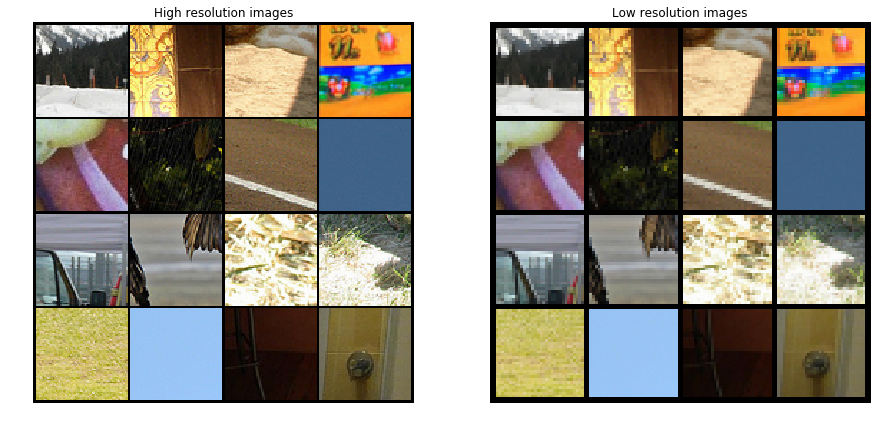

In [5]:
# Plot some training data
batch = next(iter(train_data))
utils.plot_training_images(batch, device)

## Create Generator
The Generator G is a network that takes a low-resolution image as input and outputs a high-resolution image. In practice, this is accomplished through a series of strided two dimensional convolutional transpose layers, each paired with a 2d batch norm layer and a relu activation. It is worth noting the existence of the batch norm functions after the conv-transpose layers, as this is a critical contribution of the DCGAN paper. These layers help with the flow of gradients during training.

In [6]:
netG = model.Generator(training_settings['n_gpu'], data_settings['n_channels']).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (training_settings['n_gpu'] > 1):
    netG = nn.DataParallel(netG, list(range(training_settings['n_gpu'])))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(utils.weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, t

## Create Discriminator
The discriminator D is a binary classification network that takes an image as input and outputs a scalar probability that the input image is real (as opposed to fake). Here, D takes a 3x64x64 input image, processes it through a series of Conv2d, BatchNorm2d, and LeakyReLU layers, and outputs the final probability through a Sigmoid activation function.

In [7]:
netD = model.Discriminator(training_settings['n_gpu'], data_settings['n_channels'], models_settings['ndf']).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (training_settings['n_gpu'] > 1):
    netD = nn.DataParallel(netD, list(range(training_settings['n_gpu'])))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(utils.weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


## Loss Functions and Optimizers

In [8]:
# Initialize Binary Cross Entropy loss function
criterion = nn.BCELoss()

# Setup Adam optimizers for both Generator and Discriminator
optimizerD = torch.optim.Adam(netD.parameters(), lr=training_settings['learning_rate'], betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=training_settings['learning_rate'], betas=(0.5, 0.999))

## Training Loop
We will construct different mini-batches for real and fake images, and also adjust G’s objective function to maximize logD(G(z)). 

Training is split up into two main parts. Part 1 updates the Discriminator and Part 2 updates the Generator.

### Part 1 - Train the Discriminator
The goal of training the discriminator is to maximize the probability of correctly classifying a given input as real or fake. Practically, we want to maximize log(D(x))+log(1−D(G(z))). Due to the separate mini-batch, we will calculate this in two steps. First, we will construct a batch of real samples from the training set, forward pass through D, calculate the loss log(D(x)), then calculate the gradients in a backward pass. Secondly, we will construct a batch of fake samples with the current generator, forward pass this batch through D, calculate the loss log(1−D(G(z))), and accumulate the gradients with a backward pass. Now, with the gradients accumulated from both the all-real and all-fake batches, we call a step of the Discriminator’s optimizer.

### Part 2 - Train the Generator
We want to train the Generator by minimizing log(1−D(G(z))) in an effort to generate better fakes. This was shown by Goodfellow to not provide sufficient gradients, especially early in the learning process. As a fix, we instead wish to maximize log(D(G(z))). In the code we accomplish this by: classifying the Generator output from Part 1 with the Discriminator, computing G’s loss using real labels as GT, computing G’s gradients in a backward pass, and finally updating G’s parameters with an optimizer step.

We will do some statistic reporting:

Loss_D - discriminator loss calculated as the sum of losses for the all real and all fake batches log(D(x))+log(D(G(z))).

Loss_G - generator loss calculated as log(D(G(z))).

D(x) - the average output (across the batch) of the discriminator for the all real batch. This should start close to 1 then theoretically converge to 0.5 when G gets better.

D(G(z)) - average discriminator outputs for the all fake batch. The first number is before D is updated and the second number is after D is updated. These numbers should start near 0 and converge to 0.5 as G gets better.

After each epoch we will calculate average PSNR on validation set and save the model if the metric improves.

In [9]:
# Lists to keep track of progress
G_losses = []
D_losses = []
iters = 0
max_psnr = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(training_settings['epochs']):
    # For each batch in the train_data
    for i, data in enumerate(train_data):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        label = torch.full((data_settings['batch_size'],), data_settings['real_label'], device=device)
        # Forward pass real batch through D
        output = netD(data['high_resolution'].to(device)).view(-1)
        if not output.size(0) == data_settings['batch_size']:
            continue

        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate fake image batch with G
        fake = netG(data['low_resolution'].to(device))
        label.fill_(data_settings['fake_label'])
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(data_settings['real_label'])  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 1000 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, training_settings['epochs'], i, len(train_data),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        iters += 1

    psnr = utils.test(netG, valid_data, device)
    if psnr > max_psnr:
        utils.checkpoint(netG, netD, training_settings['working_dir'])
        max_psnr = psnr

Starting Training Loop...
[0/10][0/7332]	Loss_D: 1.9925	Loss_G: 2.9191	D(x): 0.3059	D(G(z)): 0.2349 / 0.4042
[0/10][1000/7332]	Loss_D: 1.7108	Loss_G: 1.1996	D(x): 0.4464	D(G(z)): 0.4472 / 0.4083
[0/10][2000/7332]	Loss_D: 1.5016	Loss_G: 0.6480	D(x): 0.4287	D(G(z)): 0.4287 / 0.5313
[0/10][3000/7332]	Loss_D: 1.0804	Loss_G: 0.9707	D(x): 0.6090	D(G(z)): 0.4263 / 0.3969
[0/10][4000/7332]	Loss_D: 1.2268	Loss_G: 0.8624	D(x): 0.6587	D(G(z)): 0.5097 / 0.4291
[0/10][5000/7332]	Loss_D: 1.6651	Loss_G: 0.4918	D(x): 0.5673	D(G(z)): 0.6477 / 0.6235
[0/10][6000/7332]	Loss_D: 1.0698	Loss_G: 1.6214	D(x): 0.8383	D(G(z)): 0.5742 / 0.2097
[0/10][7000/7332]	Loss_D: 1.0586	Loss_G: 1.0282	D(x): 0.6563	D(G(z)): 0.4491 / 0.3624
Average PSNR: 6.90
Checkpoint saved to ..\data\models
[1/10][0/7332]	Loss_D: 1.3424	Loss_G: 0.8294	D(x): 0.4810	D(G(z)): 0.4489 / 0.4399
[1/10][1000/7332]	Loss_D: 1.3481	Loss_G: 0.7373	D(x): 0.4742	D(G(z)): 0.4495 / 0.4799
[1/10][2000/7332]	Loss_D: 1.3774	Loss_G: 0.7745	D(x): 0.5082	D(G(z

## Loss versus training iteration

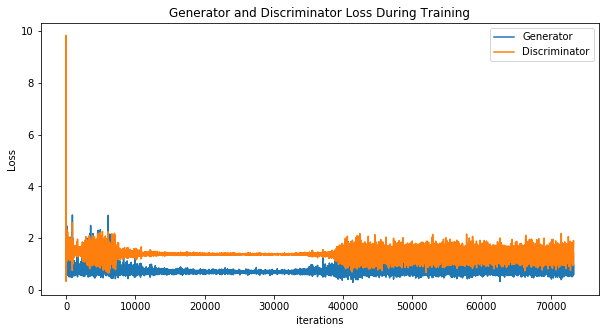

In [10]:
utils.plot_loss(G_losses, D_losses)

## Load best Generator

In [11]:
import os
best_netG = torch.load(os.path.join('..', 'data', 'models', 'modelG.pth'))
psnr = utils.test(best_netG, test_data, device)

Average PSNR: 9.67


## Real Images vs. Fake Images

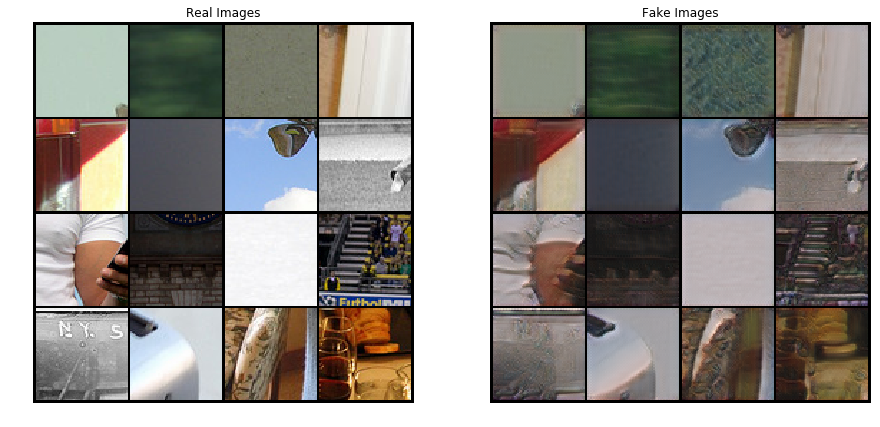

In [12]:
# Grab a batch of real images from the test_data
real_batch = next(iter(test_data))
with torch.no_grad():
    fake = best_netG(real_batch['low_resolution'].to(device)).detach()
utils.plot_real_vs_fake_images(real_batch, fake, device)